In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
import import_ipynb
from hall_data import doping, anneal

importing Jupyter notebook from hall_data.ipynb


# Get image data

In [2]:
sample_datafile = '../data/rho_c/sample_images/data.pkl'
image_df = pd.read_pickle(sample_datafile)

Filter out TNO data

In [3]:
image_df = image_df[image_df.apply(lambda x: 'TNO' not in x['sample name'], axis = 1)]

Handle sample names

In [4]:
def extract_parameters(x):
    keys = ['substrate', 'doping', 'anneal']
    values = x['sample name'].split('_')
    res = dict(zip(keys, values))
    piece = 'piece' + str(int(x.piece))
    res['piece'] = piece
    return pd.Series({**x, **res})

image_df = image_df.apply(extract_parameters, axis = 1)

Calculate sample area.

In [5]:
COIN_RADIUS = 20.25 /(2*10) # cm (diameter to radius, mm to cm)
REFERENCE_AREA = np.pi*COIN_RADIUS**2 # cm^2

def get_area(x):
    return REFERENCE_AREA*x['pixels']/x['ref pixels']

image_df = image_df.assign(area = get_area)

# Get IVt data

In [6]:
IVt_folder = '../data/rho_c/'
sys.path.append(IVt_folder)
import getData
rho_df = getData.get_all_data()

Fit measured resistance.

In [7]:
def fit_resistance(x):
    data = x.data
    [[R]] = LinearRegression().fit(data.I.values.reshape(-1,1),
                              data.V.values.reshape(-1,1)).coef_
    return R

rho_df = rho_df.apply(lambda x: pd.Series({**x, 'R' : fit_resistance(x)}), axis = 1)

# Merge image and resistance data

In [8]:
full_df = rho_df.merge(image_df, on = ['substrate', 'doping', 'anneal', 'piece'])
full_df.doping = full_df.doping.astype(doping)
full_df.anneal = full_df.doping.astype(anneal)

In [9]:
df = full_df[['substrate', 'doping', 'anneal', 'R', 'area']]

In [10]:
df = df.assign(rho_s = lambda x: x.R*x.area)
df = df.assign(rho_c = lambda x: x.rho_s/2)

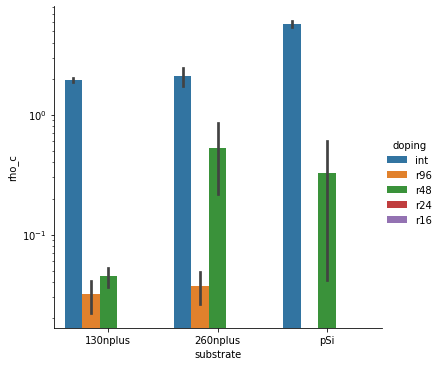

In [13]:
if __name__ == "__main__":
    import seaborn as sns
    p = sns.catplot(x = 'substrate', y = 'rho_c', hue = 'doping', kind = 'bar', data = df)
    p.set(yscale = 'log')